<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/jessy/Albedo_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter

In [19]:
# Authenticate and initialize Earth Engine
cloud_project = 'heat-index-forecasting'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

In [30]:
stations = {
    "Sinait": ee.Geometry.Point([120.459762, 17.89019]).buffer(25000),
    "Tayabas": ee.Geometry.Point([121.596575, 14.018428]).buffer(25000),
    "Tanay": ee.Geometry.Point([121.36927, 14.581167]).buffer(25000),
    "Tuguegarao": ee.Geometry.Point([121.758469, 17.647678]).buffer(25000),
    "Virac": ee.Geometry.Point([124.209834, 13.576558]).buffer(25000),
}

start_date = "2014-01-01"   # MODIS MCD43 start
end_date   = "2024-01-01"
full_range = pd.date_range(start_date, end_date, freq="D")

albedo = ee.ImageCollection("MODIS/061/MCD43A3").filterDate(start_date, end_date)

In [27]:
sample = albedo.first()
sample.bandNames().getInfo()

['Albedo_BSA_Band1',
 'Albedo_BSA_Band2',
 'Albedo_BSA_Band3',
 'Albedo_BSA_Band4',
 'Albedo_BSA_Band5',
 'Albedo_BSA_Band6',
 'Albedo_BSA_Band7',
 'Albedo_BSA_vis',
 'Albedo_BSA_nir',
 'Albedo_BSA_shortwave',
 'Albedo_WSA_Band1',
 'Albedo_WSA_Band2',
 'Albedo_WSA_Band3',
 'Albedo_WSA_Band4',
 'Albedo_WSA_Band5',
 'Albedo_WSA_Band6',
 'Albedo_WSA_Band7',
 'Albedo_WSA_vis',
 'Albedo_WSA_nir',
 'Albedo_WSA_shortwave',
 'BRDF_Albedo_Band_Mandatory_Quality_Band1',
 'BRDF_Albedo_Band_Mandatory_Quality_Band2',
 'BRDF_Albedo_Band_Mandatory_Quality_Band3',
 'BRDF_Albedo_Band_Mandatory_Quality_Band4',
 'BRDF_Albedo_Band_Mandatory_Quality_Band5',
 'BRDF_Albedo_Band_Mandatory_Quality_Band6',
 'BRDF_Albedo_Band_Mandatory_Quality_Band7',
 'BRDF_Albedo_Band_Mandatory_Quality_vis',
 'BRDF_Albedo_Band_Mandatory_Quality_nir',
 'BRDF_Albedo_Band_Mandatory_Quality_shortwave']

In [48]:
def extract_albedo(geometry, station_name):
    print(f"\n--- Processing {station_name} ---")

    def process(img):
        # Select BSA and WSA bands
        bsa = img.select("Albedo_BSA_shortwave")
        wsa = img.select("Albedo_WSA_shortwave")

        # Compute BHA (mean of BSA & WSA, apply scaling)
        bha = bsa.add(wsa).divide(2).multiply(0.001)

        return ee.Feature(
            None,
            {
                "date": img.date().format("YYYY-MM-dd"),
                "BSA": bsa.reduceRegion(
                    ee.Reducer.mean(), geometry, 500
                ).get("Albedo_BSA_shortwave"),
                "WSA": wsa.reduceRegion(
                    ee.Reducer.mean(), geometry, 500
                ).get("Albedo_WSA_shortwave"),
                "BHA": bha.reduceRegion(
                    ee.Reducer.mean(), geometry, 500
                ).get(bha.bandNames().get(0)),  # reduceRegion on computed BHA
            },
        )

    features = albedo.map(process)
    features = ee.FeatureCollection(features)

    # Convert to DataFrame
    df = geemap.ee_to_df(features)

    if df.empty:
        print(f"No data for {station_name}")
        return None

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")

    # Reindex to full daily timeline
    full_range = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")
    df = df.set_index("date").reindex(full_range)

    # Interpolate missing values
    for col in ["BSA", "WSA", "BHA"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].interpolate(method="linear").ffill().bfill()

    df.index.name = "date"
    df = df.reset_index().rename(columns={"index": "date"})
    df["station"] = station_name

    # Save to CSV
    filename = f"{station_name}_Albedo.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {df.shape[0]} rows")

    return df

In [ ]:
all_dfs = {}
for station, geom in stations.items():
    df_station = extract_albedo(geom, station)
    if df_station is not None:
        all_dfs[station] = df_station

print("\nProcessing complete!")


--- Processing Sinait ---
Saved Sinait_Albedo.csv with 3652 rows

--- Processing Tayabas ---
Saved Tayabas_Albedo.csv with 3652 rows

--- Processing Tanay ---


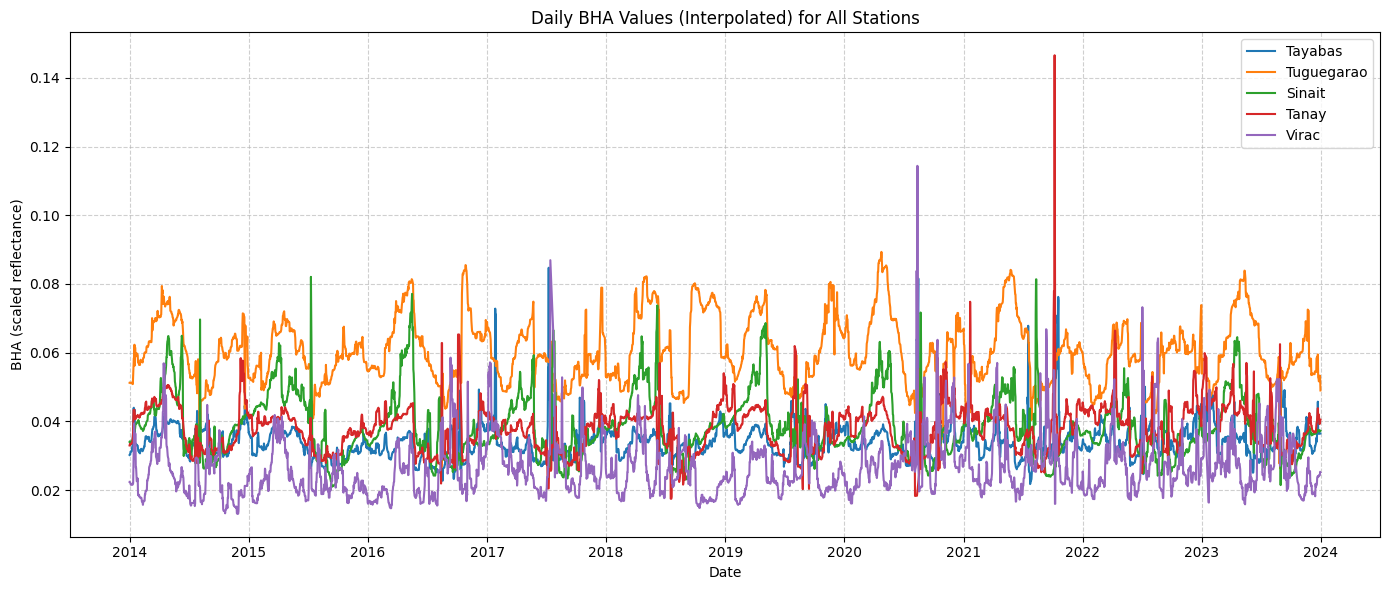

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load all station CSVs
csv_files = glob.glob("*_Albedo.csv")

plt.figure(figsize=(14, 6))

for file in csv_files:
    df = pd.read_csv(file, parse_dates=["date"])
    station_name = file.split("_")[0].capitalize()

    # Plot BHA
    plt.plot(df["date"], df["BHA"], label=station_name)

plt.title("Daily BHA Values (Interpolated) for All Stations")
plt.xlabel("Date")
plt.ylabel("BHA (scaled reflectance)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
